<a href="https://colab.research.google.com/github/pavankonam/Cognizant/blob/main/Sarimax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade pandas
!pip install --upgrade xlrd

In [2]:
import pandas as pd
df = pd.read_excel('/content/Sample-Superstore.xls')
df.head()
df.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

In [3]:
import warnings
import itertools
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
warnings.filterwarnings("ignore")
df.head(2)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820


In [4]:
df.Country.value_counts()
df.City.value_counts()

New York City      915
Los Angeles        747
Philadelphia       537
San Francisco      510
Seattle            428
                  ... 
Glenview             1
Missouri City        1
Rochester Hills      1
Palatine             1
Manhattan            1
Name: City, Length: 531, dtype: int64

In [5]:
colNames = df.columns 
for i, feature in enumerate(colNames):
  print(colNames[i] + " " + str(len(df[feature].value_counts())))

Row ID 9994
Order ID 5009
Order Date 1237
Ship Date 1334
Ship Mode 4
Customer ID 793
Customer Name 793
Segment 3
Country 1
City 531
State 49
Postal Code 631
Region 4
Product ID 1862
Category 3
Sub-Category 17
Product Name 1850
Sales 6144
Quantity 14
Discount 12
Profit 7545


In [6]:
data = df.loc[df['Category']=='Furniture']  # LOC-> :,:
#data.head()
print(data['Order Date'].min())
print(data['Order Date'].max())

2014-01-06 00:00:00
2017-12-30 00:00:00


In [7]:
df['Ship Mode'].value_counts()

Standard Class    5968
Second Class      1945
First Class       1538
Same Day           543
Name: Ship Mode, dtype: int64

In [8]:
data_grouped = data.groupby('Order Date')
data_grouped = data_grouped['Sales'].sum().reset_index()
data_grouped.tail()

,Order Date,Sales
884,2017-12-24,1393.4940
885,2017-12-25,832.4540
886,2017-12-28,551.2568
887,2017-12-29,2330.7180
888,2017-12-30,323.1360


In [9]:
data_grouped.set_index('Order Date', inplace=True)
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html
y = data_grouped['Sales'].resample('MS').mean()
y.head()

Order Date
2014-01-01    480.194231
2014-02-01    367.931600
2014-03-01    857.291529
2014-04-01    567.488357
2014-05-01    432.049188
Freq: MS, Name: Sales, dtype: float64

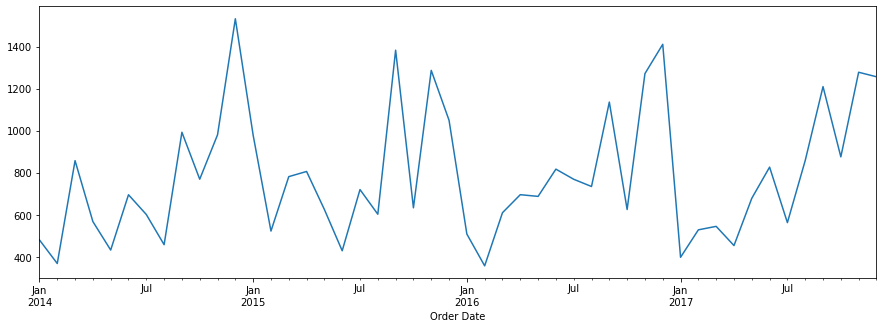

In [10]:
plt.figure()
y.plot(figsize=(15,5))
plt.show()

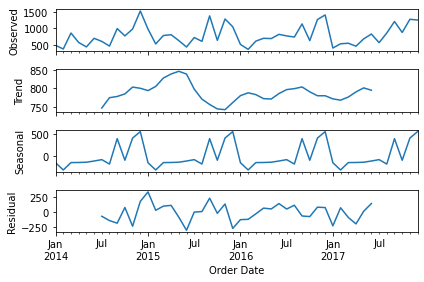

In [11]:
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html

fig = decomposition.plot()
plt.show() 

In [12]:
p = d = q = range(0,2) # VALUE generators between [0,1] 
pdq = list(itertools.product(p,d,q))
print(pdq)

[(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]


In [13]:
seasons = 12
seasonal_pdq = [   (x[0],x[1],x[2], seasons)  for x in pdq] # if x was (0,1,0), -> (0,1,0,12)
print('SARIMAX individual MODEL = {} X {}'.format(pdq[5], seasonal_pdq[0]))
print('SARIMAX individual MODEL = {} X {}'.format(pdq[5], seasonal_pdq[1]))
print('SARIMAX individual MODEL = {} X {}'.format(pdq[5], seasonal_pdq[2]))
print('SARIMAX individual MODEL = {} X {}'.format(pdq[5], seasonal_pdq[3]))

SARIMAX individual MODEL = (1, 0, 1) X (0, 0, 0, 12)
SARIMAX individual MODEL = (1, 0, 1) X (0, 0, 1, 12)
SARIMAX individual MODEL = (1, 0, 1) X (0, 1, 0, 12)
SARIMAX individual MODEL = (1, 0, 1) X (0, 1, 1, 12)


In [14]:
min_pdq = (999,999,999)
min_spdq = (999,999,999,12)
min_AIC = 999
for param in pdq:
  for sparam in seasonal_pdq:
    try:
      model = sm.tsa.statespace.SARIMAX(y, order=param, seasonal_order=sparam, enforce_stationarity=False)
      predictions = model.fit()
      print('Model={}X{}. AIC= {}'.format(param, sparam, predictions.aic))
      if(predictions.aic < min_AIC):
        min_pdq = param
        min_spdq = sparam
        min_AIC = predictions.aic
    except Exception as e:
      print(e)
      continue

print('**** Smallest PDQ,SPDQ is *****')
print(min_AIC)
print(min_pdq)
print(min_spdq)

Model=(0, 0, 0)X(0, 0, 0, 12). AIC= 769.0817523205915
Model=(0, 0, 0)X(0, 0, 1, 12). AIC= 548.1740777475707
Model=(0, 0, 0)X(0, 1, 0, 12). AIC= 477.7170130919703
maxlag should be < nobs
Model=(0, 0, 0)X(1, 0, 0, 12). AIC= 497.2314433418338
Model=(0, 0, 0)X(1, 0, 1, 12). AIC= 478.3653801879615
Model=(0, 0, 0)X(1, 1, 0, 12). AIC= 318.0047199116341
maxlag should be < nobs
Model=(0, 0, 1)X(0, 0, 0, 12). AIC= 720.9252270740013
Model=(0, 0, 1)X(0, 0, 1, 12). AIC= 514.7587035841138
Model=(0, 0, 1)X(0, 1, 0, 12). AIC= 466.55565134798553
maxlag should be < nobs
Model=(0, 0, 1)X(1, 0, 0, 12). AIC= 498.83149255463036
Model=(0, 0, 1)X(1, 0, 1, 12). AIC= 467.1039211256357
Model=(0, 0, 1)X(1, 1, 0, 12). AIC= 319.9884876946221
maxlag should be < nobs
Model=(0, 1, 0)X(0, 0, 0, 12). AIC= 677.8947668259312
Model=(0, 1, 0)X(0, 0, 1, 12). AIC= 488.7023643046859
Model=(0, 1, 0)X(0, 1, 0, 12). AIC= 486.6378567269187
maxlag should be < nobs
Model=(0, 1, 0)X(1, 0, 0, 12). AIC= 497.78896630044073
Model=(0, 1, 

In [16]:
model = sm.tsa.statespace.SARIMAX(y, order=min_pdq, seasonal_order= min_spdq, enforce_stationarity=False)
# (0, 1, 0)X(1, 0, 1, 12)
model2 = sm.tsa.statespace.SARIMAX(y, order=(0, 1, 0), seasonal_order= (1, 0, 1, 12), enforce_stationarity=False)
results = model.fit()
results2 = model2.fit()
# we've taken 2 models so that we can compare their predictions 
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                   48
Model:             SARIMAX(1, 1, 1)x(1, 1, 0, 12)   Log Likelihood                -145.301
Date:                            Wed, 06 Apr 2022   AIC                            298.602
Time:                                    12:47:24   BIC                            302.966
Sample:                                01-01-2014   HQIC                           299.630
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1279      0.308      0.415      0.678      -0.477       0.732
ma.L1         -0.9988     25.217     -0.040      0.968     -50.423      48.426
ar.S.L12      -0.2812      0.164     -1.715      0.086      -0.602       0.040
sigma2      3.031e+04   7.63e+05      0.040      0.968   -1.46e+06    1.53e+06
===================================================================================
Ljung-Box (Q):                         nan   Jarque-Bera (JB):                 0.77
Prob(Q):                               nan   Prob(JB):                         0.68
Heteroskedasticity (H):               0.67   Skew:                            -0.22
Prob(H) (two-sided):                  0.61   Kurtosis:                         2.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

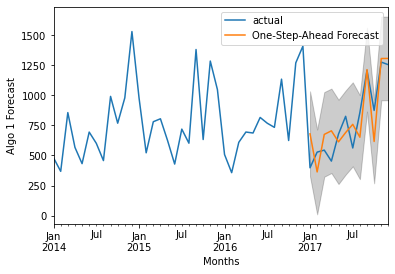

In [17]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
pred2 = results2.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred2_ci = pred2.conf_int()
ax = y['2014':].plot(label='actual') # ACTUAL DATA PLOT
pred.predicted_mean.plot(ax=ax, label='One-Step-Ahead Forecast')
# there is always a tolerance or error kernel(region) surrounding the forecast
# +- region within which mistakes are acceptable 
# THIS TOLERANCE REGION is also called CONFIDENCE INTERVAL 
ax.fill_between(pred_ci.index, pred_ci.iloc[:,0], pred_ci.iloc[:,1], color='k', alpha=0.2)
# BASE LINE-> index, lower confidence limit, upper confidence limit
ax.set_xlabel('Months')
ax.set_ylabel('Algo 1 Forecast')
plt.legend()
plt.show() 

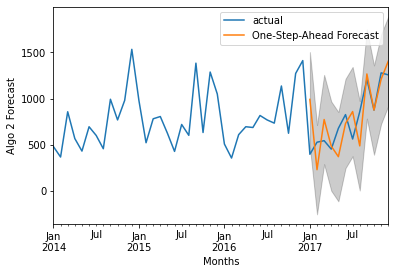

In [18]:
plt.figure()
bx = y['2014':].plot(label='actual') # ACTUAL DATA PLOT
pred2.predicted_mean.plot(ax=bx, label='One-Step-Ahead Forecast')
# there is always a tolerance or error kernel(region) surrounding the forecast
# +- region within which mistakes are acceptable 
# THIS TOLERANCE REGION is also called CONFIDENCE INTERVAL 
bx.fill_between(pred2_ci.index, pred2_ci.iloc[:,0], pred2_ci.iloc[:,1], color='k', alpha=0.2)
# BASE LINE-> index, lower confidence limit, upper confidence limit
bx.set_xlabel('Months')
bx.set_ylabel('Algo 2 Forecast')
plt.legend()
plt.show() 